In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_scheduler
)
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from deep_translator import GoogleTranslator

In [2]:
google_translator_bridge_language = GoogleTranslator(source='bn', target='hi')
google_translator = GoogleTranslator(source='hi', target='en')

In [3]:
# IHQID_1mg_train_path = "indic-health-demo/Dataset/IHQID-1mg/train.csv"
# IHQID_1mg_test_path = "indic-health-demo/Dataset/IHQID-1mg/test.csv"

IHQID_WebMD_train_path = "indic-health-demo/Dataset/IHQID-WebMD/train.csv"
IHQID_WebMD_test_path = "indic-health-demo/Dataset/IHQID-WebMD/test.csv"

IHQID_train = pd.read_csv(IHQID_WebMD_train_path)[['question_bengali', 'Manual_Intent']]
IHQID_test = pd.read_csv(IHQID_WebMD_test_path)[['question_bengali', 'Manual_Intent']]

for index in tqdm(range(len(IHQID_train['question_bengali']))):
    IHQID_train['question_bengali'][index] = google_translator_bridge_language.translate(IHQID_train['question_bengali'][index])
    IHQID_train['question_bengali'][index] = google_translator.translate(IHQID_train['question_bengali'][index])
    
for index in tqdm(range(len(IHQID_test['question_bengali']))):
    IHQID_test['question_bengali'][index] = google_translator_bridge_language.translate(IHQID_test['question_bengali'][index])
    IHQID_test['question_bengali'][index] = google_translator.translate(IHQID_test['question_bengali'][index])

IHQID_train['Manual_Intent_Encoded'] = IHQID_train['Manual_Intent']
IHQID_test['Manual_Intent_Encoded'] = IHQID_test['Manual_Intent']

label_encoder = LabelEncoder()
label_encoder.fit(IHQID_train['Manual_Intent_Encoded'])

IHQID_train['Manual_Intent_Encoded'] = label_encoder.transform(IHQID_train['Manual_Intent_Encoded'])
IHQID_test['Manual_Intent_Encoded'] = label_encoder.transform(IHQID_test['Manual_Intent_Encoded'])


100%|█████████████████████████████████████████| 241/241 [05:31<00:00,  1.38s/it]


In [4]:
IHQID_train.head()

,question_bengali,Manual_Intent,Manual_Intent_Encoded
0,What is nystatin prescribed for?,drug,1
1,Can showering after sex prevent me from gettin...,other,2
2,Percocet causes weight gain,drug,1
3,Can 2 or 2 1/2 glasses of wine a day cause hig...,disease,0
4,Can too much buttermilk cause thrush?,disease,0


In [5]:
IHQID_train.tail()

,question_bengali,Manual_Intent,Manual_Intent_Encoded
715,Can an insurance company be required to cover ...,other,2
716,How can I use duct tape to get rid of warts?,treatment plan,3
717,Bell's Palsy What facial exercises can be done...,treatment plan,3
718,Is prenatal ultrasound safe?,treatment plan,3
719,How can I reduce inguinal hernia symptoms unti...,treatment plan,3


In [6]:
IHQID_test.head()

,question_bengali,Manual_Intent,Manual_Intent_Encoded
0,How common is pregnancy after hysterectomy?,treatment plan,3
1,How effective are generic thyroid medications?,drug,1
2,Is Singulair a corticosteroid?,drug,1
3,Can you take Advil with homeopathic ear drops?,drug,1
4,Is Bell's Palsy contagious?,disease,0


In [7]:
IHQID_test.tail()

,question_bengali,Manual_Intent,Manual_Intent_Encoded
236,How will Obamacare affect Medicare recipients?...,other,2
237,What is the role of MPTP in the study of Parki...,treatment plan,3
238,Is it safe to use Botox for frown lines and wr...,disease,0
239,When should I have an ultrasound during pregna...,treatment plan,3
240,Does Nucinta have Tylenol?,drug,1


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

hyper_parameters = {
    'batch_size': 8,
    'lr': 3e-5,
    'epochs': 10
}

cuda


In [9]:
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

encoded_input_train = tokenizer.batch_encode_plus(
    IHQID_train['question_bengali'],
    add_special_tokens=True,
    padding=True,
    return_tensors='pt'
)

encoded_input_test = tokenizer.batch_encode_plus(
    IHQID_test['question_bengali'],
    add_special_tokens=True,
    padding=True,
    return_tensors='pt'
)

train_dataloader = DataLoader(
    TensorDataset(
        encoded_input_train['input_ids'].to(device),
        encoded_input_train['attention_mask'].to(device),
        torch.tensor(IHQID_train['Manual_Intent_Encoded']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)

test_dataloader = DataLoader(
    TensorDataset(
        encoded_input_test['input_ids'].to(device),
        encoded_input_test['attention_mask'].to(device),
        torch.tensor(IHQID_test['Manual_Intent_Encoded']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)


In [10]:
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=hyper_parameters['lr']
)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=0,
  num_training_steps=hyper_parameters['epochs'] * len(train_dataloader)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model.train()

updater = tqdm(range(hyper_parameters['epochs']))
for epoch in updater:
    total_train_loss = 0.0
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        
        outputs = model(**inputs)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        
        total_train_loss += loss.item()
    
    print("Epoch:", epoch + 1, " - Training Loss:", round(total_train_loss / len(train_dataloader), 4))


# Didn't have much time to implement early stopping. So, saving the model at the end of all epochs.
torch.save(model.state_dict(), f'ir_bridge_hi.model')


 10%|████▍                                       | 1/10 [00:08<01:19,  8.79s/it]

Epoch: 1  - Training Loss: 1.1519


 20%|████████▊                                   | 2/10 [00:16<01:04,  8.12s/it]

Epoch: 2  - Training Loss: 0.6595


 30%|█████████████▏                              | 3/10 [00:24<00:55,  7.87s/it]

Epoch: 3  - Training Loss: 0.343


 40%|█████████████████▌                          | 4/10 [00:31<00:46,  7.79s/it]

Epoch: 4  - Training Loss: 0.1816


 50%|██████████████████████                      | 5/10 [00:39<00:38,  7.75s/it]

Epoch: 5  - Training Loss: 0.1162


 60%|██████████████████████████▍                 | 6/10 [00:47<00:30,  7.74s/it]

Epoch: 6  - Training Loss: 0.0671


 70%|██████████████████████████████▊             | 7/10 [00:54<00:23,  7.74s/it]

Epoch: 7  - Training Loss: 0.0602


 80%|███████████████████████████████████▏        | 8/10 [01:02<00:15,  7.75s/it]

Epoch: 8  - Training Loss: 0.0213


 90%|███████████████████████████████████████▌    | 9/10 [01:10<00:07,  7.73s/it]

Epoch: 9  - Training Loss: 0.017


100%|███████████████████████████████████████████| 10/10 [01:17<00:00,  7.79s/it]

Epoch: 10  - Training Loss: 0.0182


In [12]:
model.eval()

prediction = []
gold_label = []

for batch in test_dataloader:

    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
    }

    with torch.no_grad():
        outputs = model(**inputs)

    gold_label_cpu = inputs['labels'].cpu().numpy()
    logits_vector = outputs.logits.detach().cpu().numpy()

    assert(len(gold_label_cpu) == len(logits_vector))

    for index in range(len(logits_vector)):
        prediction.append(logits_vector[index].argmax(axis=0))
        gold_label.append(gold_label_cpu[index])

print(classification_report(gold_label, prediction))


              precision    recall  f1-score   support

           0       0.83      0.78      0.80        76
           1       0.85      0.83      0.84        53
           2       0.78      0.78      0.78        73
           3       0.62      0.72      0.67        39

    accuracy                           0.78       241
   macro avg       0.77      0.78      0.77       241
weighted avg       0.79      0.78      0.78       241



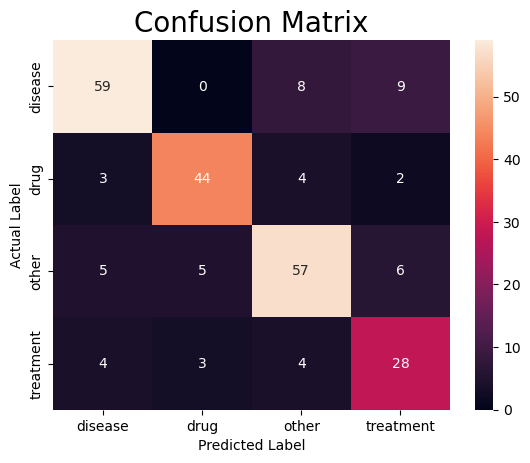

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(gold_label, prediction)

# Plot the confusion matrix.
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['disease', 'drug', 'other', 'treatment'],
    yticklabels=['disease', 'drug', 'other', 'treatment']
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('Actual Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()